In [1]:
import numpy as np
import os
import sys
import time
import argparse
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
sys.path.insert(0,'/home/prisimage/tracker/py-MDNetST/modules')
from sample_generator import *
from data_prov import *
from model import *
from bbreg import *
from options import *
from gen_config import *
from sklearn.neighbors import NearestNeighbors
def set_optimizer(model, lr_base, lr_mult=opts['lr_mult'], momentum=opts['momentum'], w_decay=opts['w_decay']):
    params = model.get_learnable_params()
    param_list = []
    for k, p in params.iteritems():
        lr = lr_base
        for l, m in lr_mult.iteritems():
            if k.startswith(l):
                lr = lr_base * m
        param_list.append({'params': [p], 'lr':lr})
    optimizer = optim.SGD(param_list, lr = lr, momentum=momentum, weight_decay=w_decay)
    return optimizer
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def forward_samples(model, image, samples, out_layer='conv3'):
    model.eval()
    extractor = RegionExtractor(image, samples, opts['img_size'], opts['padding'], opts['batch_test'])
    for i, regions in enumerate(extractor):
        regions = Variable(regions)
        if opts['use_gpu']:
            regions = regions.cuda()
        feat = model(regions, out_layer=out_layer)
        if i==0:
            feats = feat.data.clone()
        else:
            feats = torch.cat((feats,feat.data.clone()),0)
    return feats
def train(model, criterion, optimizer, pos_feats, neg_feats, maxiter, in_layer='fc4'):
    model.train()
    
    batch_pos = opts['batch_pos']
    batch_neg = opts['batch_neg']
    batch_test = opts['batch_test']
    batch_neg_cand = max(opts['batch_neg_cand'], batch_neg)

    pos_idx = np.random.permutation(pos_feats.size(0))
    neg_idx = np.random.permutation(neg_feats.size(0))
    while(len(pos_idx) < batch_pos*maxiter):
        pos_idx = np.concatenate([pos_idx, np.random.permutation(pos_feats.size(0))])
    while(len(neg_idx) < batch_neg_cand*maxiter):
        neg_idx = np.concatenate([neg_idx, np.random.permutation(neg_feats.size(0))])
    pos_pointer = 0
    neg_pointer = 0

    for iter in range(maxiter):

        # select pos idx
        pos_next = pos_pointer+batch_pos
        pos_cur_idx = pos_idx[pos_pointer:pos_next]
        pos_cur_idx = pos_feats.new(pos_cur_idx).long()
        pos_pointer = pos_next

        # select neg idx
        neg_next = neg_pointer+batch_neg_cand
        neg_cur_idx = neg_idx[neg_pointer:neg_next]
        neg_cur_idx = neg_feats.new(neg_cur_idx).long()
        neg_pointer = neg_next

        # create batch
        batch_pos_feats = Variable(pos_feats.index_select(0, pos_cur_idx))
        batch_neg_feats = Variable(neg_feats.index_select(0, neg_cur_idx))

        # hard negative mining
        if batch_neg_cand > batch_neg:
            model.eval()
            for start in range(0,batch_neg_cand,batch_test):
                end = min(start+batch_test,batch_neg_cand)
                score = model(batch_neg_feats[start:end], in_layer=in_layer)
                if start==0:
                    neg_cand_score = score.data[:,1].clone()
                else:
                    neg_cand_score = torch.cat((neg_cand_score, score.data[:,1].clone()),0)

            _, top_idx = neg_cand_score.topk(batch_neg)
            batch_neg_feats = batch_neg_feats.index_select(0, Variable(top_idx))
            model.train()
        
        # forward
        pos_score = model(batch_pos_feats, in_layer=in_layer)
        neg_score = model(batch_neg_feats, in_layer=in_layer)
        
        # optimize
        loss = criterion(pos_score, neg_score)
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), opts['grad_clip'])
        optimizer.step()

        #print "Iter %d, Loss %.4f" % (iter, loss.data[0])
#import cv2
def cvshow(img):
    cv2.imshow("Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

        
def stackList(featList):
    nframes = len(featList)
    for start in range(nframes):
        if start == 0:
            pos_data = featList[start].data.clone()
        else:
            pos_data = torch.cat((pos_data,featList[start].data.clone()),0)
    return pos_data


In [6]:
np.random.seed(123)
torch.manual_seed(456)
torch.cuda.manual_seed(789)
seq_home = '../dataset/OTB'
save_home = '../result_fig'
result_home = '../result'
        
seq_name = 'Soccer'
img_dir = os.path.join(seq_home, seq_name, 'img')
gt_path = os.path.join(seq_home, seq_name, 'groundtruth_rect.txt')

img_list = os.listdir(img_dir)
img_list.sort()
img_list = [os.path.join(img_dir,x) for x in img_list]

gt = np.loadtxt(gt_path,delimiter=',')
init_bbox = gt[0]
        
savefig_dir = os.path.join(save_home,seq_name)
result_dir = os.path.join(result_home,seq_name)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir,'result.json')
# get imglist,gt
target_bbox = np.array(init_bbox)
result = np.zeros((len(img_list),4))
result_bb = np.zeros((len(img_list),4))
result[0] = target_bbox
result_bb[0] = target_bbox
#init the first target box and result array
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"
model = MDNet(opts['model_path'])
if opts['use_gpu']:
    model = model.cuda()
model.set_learnable_params(opts['ft_layers'])
#init model and set learnable layers
criterion = BinaryLoss()

init_optimizer = set_optimizer(model, opts['lr_init'])
update_optimizer = set_optimizer(model, opts['lr_update'])
image = Image.open(img_list[0]).convert('RGB')
bbreg_examples = gen_samples(SampleGenerator('uniform', image.size, 0.3, 1.5, 1.1),target_bbox, opts['n_bbreg'], opts['overlap_bbreg'], opts['scale_bbreg'])
bbreg_feats = forward_samples(model, image, bbreg_examples)
bbreg = BBRegressor(image.size)
bbreg.train(bbreg_feats, bbreg_examples, target_bbox)
#train bbreg

In [3]:
    ##mix
    pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),
                               target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])

    neg_examples = np.concatenate([
                    gen_samples(SampleGenerator('uniform', image.size, 1, 2, 1.1), 
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init']),
                    gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init'])])
    neg_examples = np.random.permutation(neg_examples)

    # Extract pos/neg features
    pos_feats = forward_samples(model, image, pos_examples)
    neg_feats = forward_samples(model, image, neg_examples)
    feat_dim = pos_feats.size(-1)
    train(model, criterion, init_optimizer, pos_feats, neg_feats, opts['maxiter_init'])

/home/prisimage/tracker/py-MDNetST/modules/model.py:151: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pos_loss0 = -F.log_softmax(-1*pos_score)[:,0]
/home/prisimage/tracker/py-MDNetST/modules/model.py:152: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pos_loss1 = -F.log_softmax(pos_score)[:,1]
/home/prisimage/tracker/py-MDNetST/modules/model.py:153: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  neg_loss0 = -F.log_softmax(-1*neg_score)[:,1]
/home/prisimage/tracker/py-MDNetST/modules/model.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  neg_loss1 = -F.log_softmax(neg_score)[:,0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:128: UserWarning: torch.n

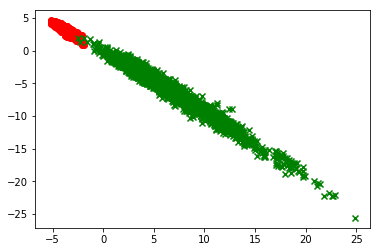

In [4]:
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')

plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')

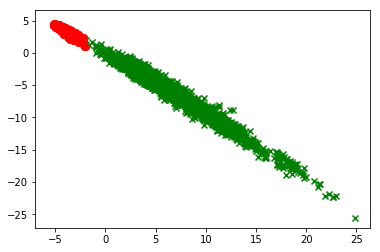

In [5]:
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')
plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')


In [7]:
    ##class1: pure bg
    pos_examples1 = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),
                               target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
    neg_examples1 = gen_samples(SampleGenerator('uniform', image.size, 1,2,1.1),target_bbox, 1000, [0,0.1])
    pos_feats1 = forward_samples(model, image, pos_examples1)
    neg_feats1 = forward_samples(model, image, neg_examples1)
    ##class2:over include
    pos_examples2 = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),
                           target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
    neg_examples2 = gen_samples(SampleGenerator('hole', image.size, 0.3,2.0),target_bbox, 1000, [0,0.5])
    pos_feats2 = forward_samples(model, image, pos_examples2)
    neg_feats2 = forward_samples(model, image, neg_examples2)
    ##class3:part+bg
    pos_examples3 = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),
                           target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
    neg_examples3 = gen_samples(SampleGenerator('edge', image.size, 1,2.0,1.1),target_bbox, 1000, [0.2,0.6])
    pos_feats3 = forward_samples(model, image, pos_examples3)
    neg_feats3 = forward_samples(model, image, neg_examples3)
    ##class4:pure part
    pos_examples4 = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),target_bbox,
                           opts['n_pos_init'], opts['overlap_pos_init'])
    neg_examples4 = gen_samples(SampleGenerator('part', image.size, 1,2.0,1.1),target_bbox, 1000, [0.2,0.6])
    pos_feats4 = forward_samples(model, image, pos_examples4)
    neg_feats4 = forward_samples(model, image, neg_examples4)
    
    
    # Initial training
    train(model, criterion, init_optimizer, pos_feats1, neg_feats1, opts['maxiter_init'])
    train(model, criterion, init_optimizer, pos_feats2, neg_feats2, opts['maxiter_init'])
    train(model, criterion, init_optimizer, pos_feats3, neg_feats3, opts['maxiter_init'])
    train(model, criterion, init_optimizer, pos_feats4, neg_feats4, opts['maxiter_init'])
    
    ##mix
    pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 0.1, 1.2),
                               target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])

    neg_examples = np.concatenate([
                    gen_samples(SampleGenerator('uniform', image.size, 1, 2, 1.1), 
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init']),
                    gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init'])])
    neg_examples = np.random.permutation(neg_examples)

    # Extract pos/neg features
    pos_feats = forward_samples(model, image, pos_examples)
    neg_feats = forward_samples(model, image, neg_examples)
    feat_dim = pos_feats.size(-1)
    train(model, criterion, init_optimizer, pos_feats, neg_feats, opts['maxiter_init'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:128: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


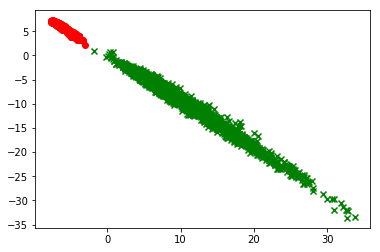

In [8]:
pos_out = forward_samples(model, image, pos_examples,out_layer='fc6')
neg_out = forward_samples(model, image, neg_examples,out_layer='fc6')

plt.scatter(pos_out[:,0],pos_out[:,1],c='r',marker='o')
plt.scatter(neg_out[:,0],neg_out[:,1],c='g',marker='x')

In [18]:
    # Init sample generators
    sample_generator = SampleGenerator('gaussian', image.size, opts['trans_f'], opts['scale_f'], valid=True)
    pos_generator1 = SampleGenerator('gaussian', image.size, 0.1, 1.2)
    pos_generator2 = SampleGenerator('gaussian', image.size, 0.1, 1.2)
    pos_generator3 = SampleGenerator('gaussian', image.size, 0.1, 1.2)
    pos_generator4 = SampleGenerator('gaussian', image.size, 0.1, 1.2)
    #neg_generator = SampleGenerator('uniform', image.size, 1.5, 1.2)
    neg_generator1 = SampleGenerator('uniform', image.size, 1,2,1.1)
    neg_generator2 = SampleGenerator('hole', image.size, 0.3,2.0)
    neg_generator3 = SampleGenerator('edge', image.size, 1,2.0,1.1)
    neg_generator4 = SampleGenerator('part', image.size, 1,2.0,1.1)
    
    pos_generator = SampleGenerator('gaussian', image.size, 0.1, 1.2)
    neg_generator = SampleGenerator('uniform', image.size, 1.5, 1.2)

    # Init pos/neg features for update
    pos_feats_all1 = [pos_feats1[:opts['n_pos_update']]]
    pos_feats_all2 = [pos_feats2[:opts['n_pos_update']]]
    pos_feats_all3 = [pos_feats3[:opts['n_pos_update']]]
    pos_feats_all4 = [pos_feats4[:opts['n_pos_update']]]
    neg_feats_all1 = [neg_feats1[:opts['n_neg_update']]]
    neg_feats_all2 = [neg_feats2[:opts['n_neg_update']]]
    neg_feats_all3 = [neg_feats3[:opts['n_neg_update']]]
    neg_feats_all4 = [neg_feats4[:opts['n_neg_update']]]
    
    pos_feats_all = [pos_feats[:opts['n_pos_update']]]
    neg_feats_all = [neg_feats[:opts['n_neg_update']]]

In [19]:
i= 0

In [20]:
        i=i+1
        image = Image.open(img_list[i]).convert('RGB')

        # Estimate target bbox
        samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
        sample_scores = forward_samples(model, image, samples, out_layer='fc6')
        top_scores, top_idx = sample_scores[:,1].topk(5)
        top_idx = top_idx.cpu().numpy()
        target_score = top_scores.mean()
        target_bbox = samples[top_idx].mean(axis=0)

        success = target_score > opts['success_thr']

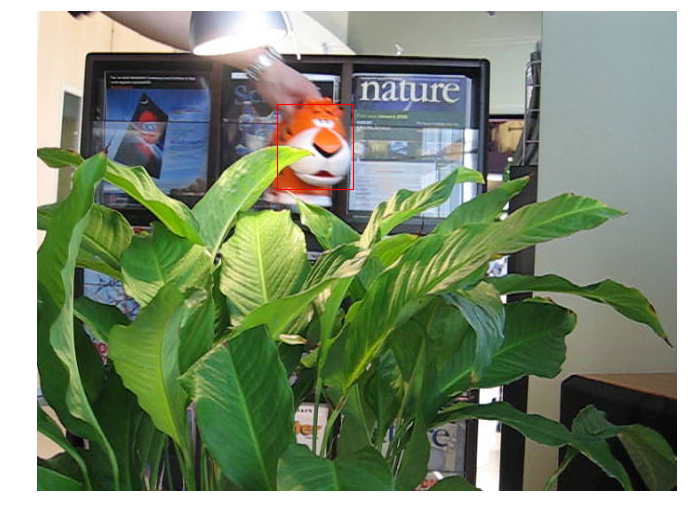

In [21]:
show_result(image,target_bbox)

In [23]:
        # Expand search area at failure
        if success:
            sample_generator.set_trans_f(opts['trans_f'])
        else:
            sample_generator.set_trans_f(opts['trans_f_expand'])

        # Bbox regression
        if success:
            bbreg_samples = samples[top_idx]
            bbreg_feats = forward_samples(model, image, bbreg_samples)
            bbreg_samples = bbreg.predict(bbreg_feats, bbreg_samples)
            bbreg_bbox = bbreg_samples.mean(axis=0)
        else:
            bbreg_bbox = target_bbox
        
        # Copy previous result at failure
        if not success:
            target_bbox = result[i-1]
            bbreg_bbox = result_bb[i-1]
        
        # Save result
        result[i] = target_bbox
        result_bb[i] = bbreg_bbox

        # Data collect
        if success:
            # Draw pos/neg samples
            pos_examples1 = gen_samples(pos_generator1, target_bbox, 
                                       opts['n_pos_update'],
                                       opts['overlap_pos_update'])
            pos_examples2 = gen_samples(pos_generator2, target_bbox, 
                                       opts['n_pos_update'],
                                       opts['overlap_pos_update'])
            pos_examples3 = gen_samples(pos_generator3, target_bbox, 
                                       opts['n_pos_update'],
                                       opts['overlap_pos_update'])
            pos_examples4 = gen_samples(pos_generator4, target_bbox, 
                                       opts['n_pos_update'],
                                       opts['overlap_pos_update'])
            '''
            neg_examples = gen_samples(neg_generator, target_bbox, 
                                       opts['n_neg_update'],
                                       opts['overlap_neg_update'])
            '''
            neg_examples1 = gen_samples(neg_generator1,target_bbox, 200, [0,0.1])
            neg_examples2 = gen_samples(neg_generator2,target_bbox, 200, [0,0.5])
            neg_examples3 = gen_samples(neg_generator3,target_bbox, 200, [0.2,0.6])
            neg_examples4 = gen_samples(neg_generator4,target_bbox, 200, [0.2,0.6])
            
            # Extract pos/neg features
            pos_feats1 = forward_samples(model, image, pos_examples1)
            pos_feats2 = forward_samples(model, image, pos_examples2)
            pos_feats3 = forward_samples(model, image, pos_examples3)
            pos_feats4 = forward_samples(model, image, pos_examples4)
            #neg_feats = forward_samples(model, image, neg_examples)
            neg_feats1 = forward_samples(model, image, neg_examples1)
            neg_feats2 = forward_samples(model, image, neg_examples2)
            neg_feats3 = forward_samples(model, image, neg_examples3)
            neg_feats4 = forward_samples(model, image, neg_examples4)
            
            pos_feats_all1.append(pos_feats1)
            pos_feats_all2.append(pos_feats2)
            pos_feats_all3.append(pos_feats3)
            pos_feats_all4.append(pos_feats4)
            #neg_feats_all.append(neg_feats)
            neg_feats_all1.append(neg_feats1)
            neg_feats_all2.append(neg_feats2)
            neg_feats_all3.append(neg_feats3)
            neg_feats_all4.append(neg_feats4)
            if len(pos_feats_all1) > opts['n_frames_long']:
                del pos_feats_all1[0]
            if len(pos_feats_all2) > opts['n_frames_long']:
                del pos_feats_all2[0]
            if len(pos_feats_all3) > opts['n_frames_long']:
                del pos_feats_all3[0]
            if len(pos_feats_all4) > opts['n_frames_long']:
                del pos_feats_all4[0]
            if len(neg_feats_all1) > opts['n_frames_short']:
                del neg_feats_all1[0]
            if len(neg_feats_all2) > opts['n_frames_short']:
                del neg_feats_all2[0]
            if len(neg_feats_all3) > opts['n_frames_short']:
                del neg_feats_all3[0]
            if len(neg_feats_all4) > opts['n_frames_short']:
                del neg_feats_all4[0]
                
            # Draw pos/neg samples
            pos_examples = gen_samples(pos_generator, target_bbox, 
                                       opts['n_pos_update'],
                                       opts['overlap_pos_update'])
            neg_examples = gen_samples(neg_generator, target_bbox, 
                                       opts['n_neg_update'],
                                       opts['overlap_neg_update'])

            # Extract pos/neg features
            pos_feats = forward_samples(model, image, pos_examples)
            neg_feats = forward_samples(model, image, neg_examples)
            pos_feats_all.append(pos_feats)
            neg_feats_all.append(neg_feats)
            if len(pos_feats_all) > opts['n_frames_long']:
                del pos_feats_all[0]
            if len(neg_feats_all) > opts['n_frames_short']:
                del neg_feats_all[0]
            

In [54]:
            nframes = min(opts['n_frames_short'],len(pos_feats_all))
            pos_data1 = stackList(pos_feats_all1[-nframes:])
            pos_data2 = stackList(pos_feats_all2[-nframes:])
            pos_data3 = stackList(pos_feats_all3[-nframes:])
            pos_data4 = stackList(pos_feats_all4[-nframes:])
            #neg_data = torch.stack(neg_feats_all,0).view(-1,feat_dim)
            neg_data1 = stackList(neg_feats_all1)
            neg_data2 = stackList(neg_feats_all2)
            neg_data3 = stackList(neg_feats_all3)
            neg_data4 = stackList(neg_feats_all4)
            train(model, criterion, update_optimizer, pos_data1, neg_data1, opts['maxiter_update'])
            train(model, criterion, update_optimizer, pos_data2, neg_data2, opts['maxiter_update'])
            train(model, criterion, update_optimizer, pos_data3, neg_data3, opts['maxiter_update'])
            train(model, criterion, update_optimizer, pos_data4, neg_data4, opts['maxiter_update'])
            
            pos_data = stackList(pos_feats_all[-nframes:])
            neg_data = stackList(neg_feats_all)
            train(model, criterion, update_optimizer, pos_data, neg_data, opts['maxiter_update'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:128: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
